# Projet 5 - Catégorisez automatiquement des questions

## Importation des librairies et des données

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn import decomposition
from nltk.tokenize import word_tokenize
pd.options.mode.chained_assignment = None  # default='warn'
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk import *
import csv

In [101]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [102]:
print(train.shape)
print(test.shape)

(204432, 9)
(51109, 9)


## Nettoyage des données

In [103]:
# Le jeu de données étant trop grand pour certaines étapes, nous avons commencé par diviser le jeu de données train et test par 2
train_df = train.sample(frac=0.5)
test_df = test.sample(frac=0.5)

In [104]:
print(train_df.shape)
print(test_df.shape)

(102216, 9)
(25554, 9)


In [105]:
train_df.dropna(subset=['Title'], inplace = True)

In [106]:
train_df['Body'] = train_df['Title'] + ' ' + train_df['Body']
test_df['Body'] = test_df['Title'] + ' ' + test_df['Body']

In [107]:
train_df['processed_tags'] = train_df['Tags'].str.findall("<(.*?)>")
test_df['processed_tags'] = test_df['Tags'].str.findall("<(.*?)>")
train_df['Body'] = train_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
test_df['Body'] = test_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
train_df['Body'] = train_df['Body'].map(lambda x: x.replace('\n', ' '))
test_df['Body'] = test_df['Body'].map(lambda x: x.replace('\n', ' '))
train_df = train_df.drop(['Tags', 'Title'], axis = 1)
test_df = test_df.drop(['Tags', 'Title'], axis = 1)

### Définition des fonctions de nettoyage

In [108]:
def tokenization(sentence):
    token = RegexpTokenizer(r'[a-zA-Z]+')
    return token.tokenize(sentence.lower())

stop_words = set(stopwords.words('english'))
def clean_stopwords(sentence):
    return [word for word in sentence if not word in stop_words]

lemmatizer = WordNetLemmatizer()
def lemmatisation(sentence):
    return [lemmatizer.lemmatize(word) for word in sentence]

#### Exemple

In [109]:
example_sentence = 'Hello, this are 3 examples to show the different steps of the cleaning process.'

In [110]:
tok_sentence = tokenization(example_sentence)
clean_sentence = clean_stopwords(tok_sentence)
lemm_sentence = lemmatisation(clean_sentence)

In [111]:
print('Phrase originale: ', example_sentence, '\n')
print('Phrase tokenisée, en minuscules et sans ponctuation:', tok_sentence, '\n')
print('Phrase sans les stop words: ', clean_sentence, '\n')
print('Phrase lemmatisée: ', lemm_sentence)

Phrase originale:  Hello, this are 3 examples to show the different steps of the cleaning process. 

Phrase tokenisée, en minuscules et sans ponctuation: ['hello', 'this', 'are', 'examples', 'to', 'show', 'the', 'different', 'steps', 'of', 'the', 'cleaning', 'process'] 

Phrase sans les stop words:  ['hello', 'examples', 'show', 'different', 'steps', 'cleaning', 'process'] 

Phrase lemmatisée:  ['hello', 'example', 'show', 'different', 'step', 'cleaning', 'process']


#### Application sur le jeu de données

In [112]:
train_df['processed_body'] = train_df['Body'].map(lambda x: tokenization(x))
test_df['processed_body'] = test_df['Body'].map(lambda x: tokenization(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: lemmatisation(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: lemmatisation(x))
train_df['processed_body_2'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body_2'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))

## Nettoyage des tags

### Suppression de tags 

In [113]:
full_df = pd.concat([train_df,test_df])

In [114]:
full_df.shape

(127770, 10)

In [115]:
tags_count = pd.Series([item for sublist in full_df['processed_tags'].tolist() for item in sublist]).value_counts()
n_top_tags = 20
tags_filter = train_df['processed_tags'].map(lambda x: any(elem in x for elem in tags_count[:n_top_tags].index.tolist()))
filtered_df = train_df[tags_filter]
filtered_df.shape

(69480, 10)

In [116]:
tags_filter_test = test_df['processed_tags'].map(lambda x: any(elem in x for elem in tags_count[:n_top_tags].index.tolist()))
filtered_test_df = test_df[tags_filter_test]

In [117]:
full_filtered_df = pd.concat([filtered_df, filtered_test_df])
full_filtered_df.shape

(86748, 10)

### Fréquence des tags

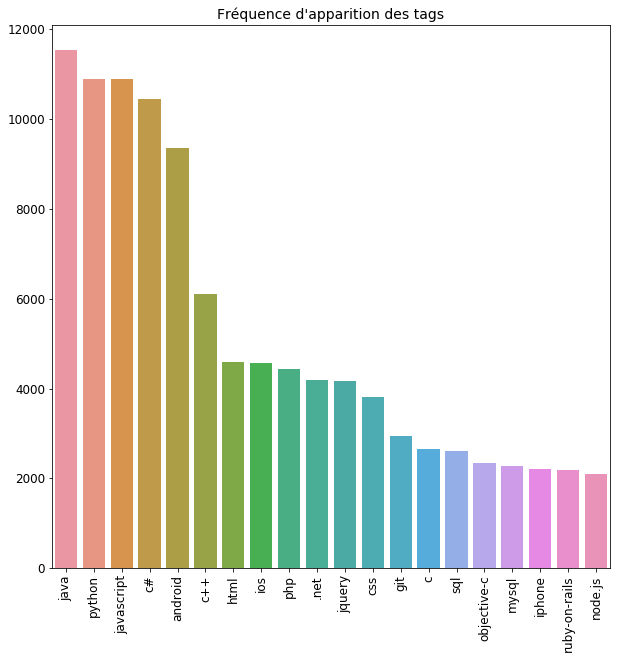

In [118]:
plt.figure(figsize=(10,10))
sns.barplot(x = tags_count[:20].index , y = tags_count[:20])
plt.title('Fréquence d\'apparition des tags', fontsize = 14)
plt.xticks(label = 'Tags', rotation = 90, fontsize = 12)
plt.yticks(label = 'Nombre d\'apparition', fontsize = 12);

## Fréquence des termes

In [119]:
body_list = filtered_df['processed_body'].tolist()

In [120]:
fw_counts = Counter([elt for lst in body_list for elt in lst])
fw_common_words = [word[0] for word in fw_counts.most_common(25)]
fw_common_counts = [word[1] for word in fw_counts.most_common(25)]

In [121]:
fw_words_total = [word[0] for word in fw_counts.most_common()]
fw_counts_total = [word[1] for word in fw_counts.most_common()]

In [122]:
fw_counts_number = pd.Series(fw_counts_total)

In [123]:
len(fw_counts_number)

146158

In [124]:
limite = 500
print('Limite fixée: ', limite)

Limite fixée:  500


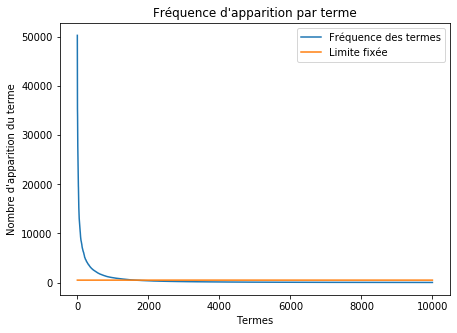

In [125]:
plt.figure(figsize=(7,5))
plt.plot(range(10000), fw_counts_number.iloc[0:10000], label='Fréquence des termes')
plt.plot(range(10000), [limite]*10000, label = 'Limite fixée')
plt.xlabel('Termes')
plt.ylabel('Nombre d\'apparition du terme')
plt.title('Fréquence d\'apparition par terme')
plt.legend();

### Suppressions des termes les moins fréquents

In [126]:
stop_words = set(stopwords.words('english'))

fw_dict = dict(fw_counts)

In [127]:
fw_dict = dict(fw_counts)
del_words = []
for key, value in fw_dict.items():
    if value <= limite:
        stop_words.add(key) #ajouts des mots à la liste de stopwords
        del_words.append(key)
[fw_dict.pop(key) for key in del_words]

[189,
 196,
 80,
 15,
 45,
 435,
 1,
 287,
 327,
 218,
 97,
 40,
 61,
 418,
 308,
 426,
 402,
 245,
 358,
 55,
 34,
 2,
 163,
 4,
 61,
 216,
 312,
 178,
 481,
 216,
 265,
 338,
 90,
 155,
 477,
 317,
 298,
 3,
 225,
 7,
 4,
 90,
 281,
 48,
 155,
 4,
 3,
 1,
 2,
 23,
 178,
 204,
 92,
 496,
 8,
 498,
 7,
 442,
 118,
 388,
 381,
 127,
 222,
 9,
 9,
 72,
 40,
 34,
 3,
 231,
 16,
 88,
 3,
 1,
 1,
 1,
 11,
 55,
 191,
 452,
 14,
 3,
 2,
 175,
 421,
 2,
 244,
 106,
 171,
 2,
 3,
 108,
 9,
 186,
 19,
 243,
 261,
 386,
 416,
 20,
 126,
 180,
 355,
 1,
 1,
 2,
 8,
 8,
 2,
 178,
 193,
 33,
 106,
 75,
 39,
 24,
 75,
 14,
 3,
 230,
 7,
 5,
 1,
 120,
 146,
 303,
 1,
 208,
 143,
 22,
 285,
 185,
 333,
 85,
 17,
 76,
 463,
 131,
 104,
 322,
 87,
 129,
 58,
 260,
 4,
 4,
 430,
 97,
 12,
 23,
 114,
 127,
 176,
 55,
 50,
 459,
 197,
 291,
 52,
 228,
 1,
 2,
 124,
 245,
 84,
 475,
 472,
 294,
 315,
 16,
 394,
 21,
 62,
 262,
 5,
 255,
 434,
 102,
 476,
 490,
 246,
 497,
 2,
 22,
 336,
 4,
 190,
 4,
 67,
 2

In [128]:
sorted(fw_dict.items(), key=lambda t: t[0])

[('ab', 652),
 ('abc', 939),
 ('able', 4979),
 ('absolute', 774),
 ('abstract', 1035),
 ('accept', 1051),
 ('access', 5358),
 ('accomplish', 602),
 ('according', 1128),
 ('account', 1716),
 ('achieve', 1631),
 ('across', 1247),
 ('action', 5040),
 ('actionbar', 622),
 ('active', 1603),
 ('activerecord', 696),
 ('activity', 5511),
 ('activitythread', 2256),
 ('actual', 1452),
 ('actually', 2843),
 ('ad', 815),
 ('adapter', 890),
 ('adb', 562),
 ('add', 12723),
 ('added', 3198),
 ('adding', 2347),
 ('additional', 906),
 ('address', 3032),
 ('admin', 1083),
 ('advance', 1503),
 ('advantage', 702),
 ('advice', 601),
 ('age', 906),
 ('agent', 504),
 ('ajax', 2378),
 ('alert', 2292),
 ('algorithm', 1092),
 ('align', 1198),
 ('alloc', 1033),
 ('allow', 1923),
 ('allowed', 994),
 ('allows', 825),
 ('almost', 702),
 ('along', 749),
 ('alpha', 721),
 ('already', 4055),
 ('also', 10167),
 ('alternative', 1020),
 ('although', 810),
 ('always', 3414),
 ('amount', 1052),
 ('android', 50333),
 ('andr

In [129]:
fw_dict

{'event': 6948,
 'using': 35109,
 'jquery': 7171,
 'working': 6924,
 'like': 30914,
 'toggle': 591,
 'flag': 1700,
 'true': 11416,
 'whenever': 746,
 'user': 20722,
 'change': 10101,
 'value': 26458,
 'field': 6288,
 'one': 18945,
 'instance': 4628,
 'class': 39197,
 'get': 34081,
 'somehow': 876,
 'never': 1927,
 'keyword': 883,
 'combination': 501,
 'seems': 6560,
 'nothing': 2261,
 'result': 10305,
 'google': 7116,
 'thanks': 6698,
 'help': 6703,
 'edit': 6179,
 'var': 14317,
 'click': 4784,
 'function': 26907,
 'alert': 2292,
 'test': 17390,
 'tried': 9949,
 'code': 31917,
 'work': 19526,
 'give': 4343,
 'error': 28882,
 'meaning': 605,
 'find': 10767,
 'object': 19462,
 'reason': 3347,
 'listener': 760,
 'also': 10167,
 'replace': 2340,
 'name': 27135,
 'textarea': 581,
 'know': 13663,
 'trying': 10403,
 'convert': 3886,
 'read': 7150,
 'text': 15616,
 'file': 37234,
 'line': 13562,
 'asset': 1286,
 'directory': 4209,
 'android': 50333,
 'want': 22476,
 'able': 4979,
 'use': 28223

### Word cloud

In [130]:
wordcloud = WordCloud(stopwords=stop_words).generate_from_frequencies(fw_counts)

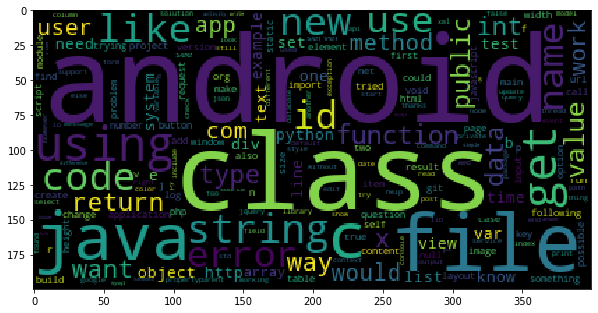

In [131]:
plt.figure(figsize = (10,9))
plt.imshow(wordcloud);

## Tf-idf

### CountVectorizer

In [81]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        token = RegexpTokenizer(r'[a-zA-Z]+')
        return [self.wnl.lemmatize(t) for t in token.tokenize(doc.lower()) if t not in stop_words]
wnl = WordNetLemmatizer()    
tokenizer = lambda x: [wnl.lemmatize(x) for x in token.tokenize(x.lower()) if x not in stop_words]
    
    
count = CountVectorizer(tokenizer=LemmaTokenizer(),
                        stop_words=stop_words, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [82]:
pipe.fit(filtered_df["Body"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words={'a', 'aa', 'aaa', 'aaaa', 'aaaaa',
                                             'aaaaaa', 'aaaaaaa', 'aaaaaaaa',
                                             'aaaaaaaaa', 'aaaaaaaaaa',
                                             'aaaaaaaaaaa', 'aaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaa...
                                             'aaaaaaaaaaaaaaaaaadwpwaaaaaaaabaaaaaaaaaceaaaaaaaaaqqaaaaaaaabraaaaaaaaageaaaaaaaaacqaaaaaaaacbaaaaaaaaaikaaaaaaaa

In [83]:
train_feature = pipe.transform(filtered_df["Body"])
train_feature

<69558x1624 sparse matrix of type '<class 'numpy.float64'>'
	with 2390868 stored elements in Compressed Sparse Row format>

In [84]:
feature_names = count.get_feature_names()

In [85]:
len(feature_names)

1624

In [86]:
feature_names

['ab',
 'abc',
 'able',
 'absolute',
 'abstract',
 'accept',
 'access',
 'accomplish',
 'according',
 'account',
 'achieve',
 'across',
 'action',
 'actionbar',
 'active',
 'activerecord',
 'activity',
 'activitythread',
 'actual',
 'actually',
 'ad',
 'adapter',
 'adb',
 'add',
 'added',
 'adding',
 'additional',
 'address',
 'admin',
 'advance',
 'advantage',
 'advice',
 'age',
 'agent',
 'ajax',
 'alert',
 'algorithm',
 'alias',
 'align',
 'alloc',
 'allow',
 'allowed',
 'allows',
 'almost',
 'along',
 'alpha',
 'already',
 'also',
 'alternative',
 'although',
 'always',
 'amount',
 'android',
 'androidruntime',
 'angular',
 'angularjs',
 'animated',
 'animation',
 'annotation',
 'anonymous',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'apache',
 'api',
 'apk',
 'app',
 'apparently',
 'appcompat',
 'appear',
 'appears',
 'append',
 'apple',
 'application',
 'apply',
 'appreciate',
 'appreciated',
 'approach',
 'appropriate',
 'apps',
 'archite

In [87]:
test_feature = pipe.transform(filtered_test_df["Body"])

In [88]:
#dense_train = train_feature.todense()
#denselist_train = dense_train.tolist()
#train_mx = pd.DataFrame(denselist_train, columns= feature_names)

In [89]:
#dense_test = test_feature.todense()
#denselist_test = dense_test.tolist()
#test_mx = pd.DataFrame(denselist_test, columns= feature_names)

In [90]:
train_mx =  pd.DataFrame(train_feature.toarray(), columns = feature_names)
test_mx = pd.DataFrame(test_feature.toarray(), columns = feature_names)

In [91]:
test_mx.head()

,ab,abc,able,absolute,abstract,accept,access,accomplish,according,account,...,xsd,xxx,year,yes,yet,yield,z,zero,zip,zygoteinit
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.006613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.089692,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Exportation des données

In [92]:
test_mx.to_csv('test_mx.csv', sep=';')
train_mx.to_csv('train_mx.csv', sep=';')

In [93]:
type(filtered_df['processed_tags'].iloc[0])

list

In [94]:
filtered_test_df.to_csv('processed_test_df.csv', sep=';')
filtered_df.to_csv('processed_train_df.csv', sep=';')

In [95]:
#csv_columns = ['Key','Value']
with open('fw_dict.csv', 'w') as f: 
    w = csv.DictWriter(f, fw_dict.keys())
    w.writeheader()
    w.writerow(fw_dict)

In [96]:
with open('feature_name.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in feature_names:
        writer.writerow([val])